# Show that Triton autotune is broken due to warmup issues

### Aim

Create an instance of Triton kernel + @autotune on a100 where the autotuner picks the wrong config, due to `do_bench` not doing enough warmup by default.

### Plan

- Test the hypothesis that warmup can occasionally take more than 25 ms, which is the default `do_bench` warmup time.

## Kernel which doesn't warmup in 25ms

Try using `triton.ops.flash_attention._fwd_kernel` - an important kernel since it's in the library and it's a commonly used kernel.

In [1]:
# Based on `test/unit/operators/test_flash_attention.test_op`.
import torch


def make_fa_tensors(Z, H, N_CTX, D_HEAD, dtype=torch.float16):

    q = torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.1, std=0.2).requires_grad_()
    k = torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.4, std=0.2).requires_grad_()
    v = torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.3, std=0.2).requires_grad_()

    return q, k, v

# Same values as unit test.
q, k, v = make_fa_tensors(4, 48, 1024, 64)

In [7]:
import triton
from triton.ops.flash_attention import _fwd_kernel

# Based on `triton.ops.attention.forward` - but with `BLOCK` exposed.
def dispatch_fa(q, k, v, BLOCK, sm_scale = 0.2):

    # only support for Ampere now
    capability = torch.cuda.get_device_capability()
    if capability[0] < 8:
        raise RuntimeError("Flash attention currently only supported for compute capability >= 80")
    assert BLOCK in {128, 256} # Other values may crash.
    # shape constraints
    Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
    assert Lq == Lk and Lk == Lv
    # assert Lk in {16, 32, 64, 128}
    assert Lk in {64}  # TODO: fix other cases
    o = torch.empty_like(q)
    grid = (triton.cdiv(q.shape[2], BLOCK), q.shape[0] * q.shape[1], 1)
    L = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
    m = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
    num_warps = 4 if Lk <= 64 else 8

    _fwd_kernel[grid](
        q, k, v, sm_scale,
        L, m,
        o,
        q.stride(0), q.stride(1), q.stride(2), q.stride(3),
        k.stride(0), k.stride(1), k.stride(2), k.stride(3),
        v.stride(0), v.stride(1), v.stride(2), v.stride(3),
        o.stride(0), o.stride(1), o.stride(2), o.stride(3),
        q.shape[0], q.shape[1], q.shape[2],
        BLOCK_M=BLOCK, BLOCK_N=BLOCK,
        BLOCK_DMODEL=Lk, num_warps=num_warps,
        num_stages=2,
    )

    return o

In [8]:
from triton.ops import attention

attention(q, k, v, 0.2).shape

torch.Size([4, 48, 1024, 64])

In [9]:
dispatch_fa(q, k, v, 256, 64).shape

torch.Size([4, 48, 1024, 64])

In [12]:
from triton.testing import do_bench
from time import sleep

print(do_bench(lambda: dispatch_fa(q, k, v, 256, 64))[0])
sleep(2)
print(do_bench(lambda: dispatch_fa(q, k, v, 128, 0.2))[0])

17.117183685302734
0.37171199917793274


In [3]:
from conch.bench import running_times, fit_gaussian_mixture

In [4]:
times = running_times(lambda: attention(q, k, v, 0.2), 1024)

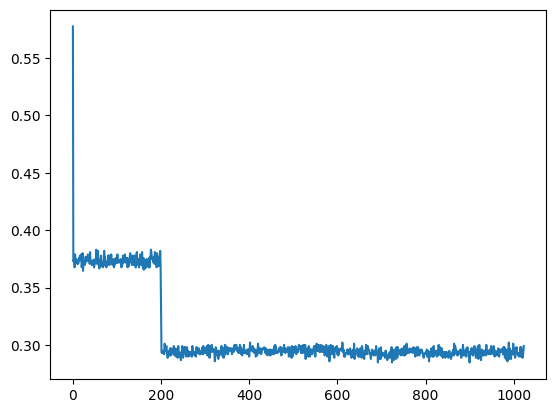

In [5]:
from matplotlib import pyplot as plt
plt.plot(times)

In [6]:
q2, k2, v2 = make_fa_tensors(8, 96, 2048, 64)

In [7]:
times = running_times(lambda: attention(q2, k2, v2, 0.2), 1024)

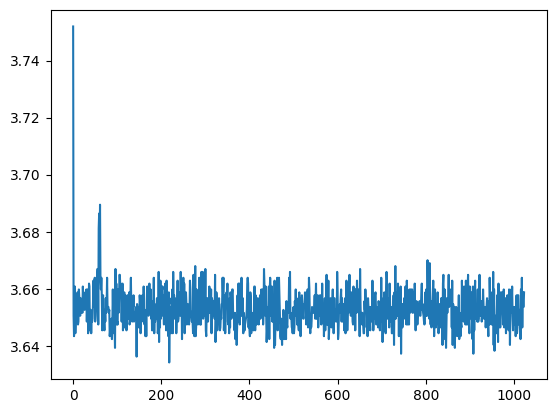

In [8]:
plt.plot(times)

In [9]:
fit_gaussian_mixture(times)

RunningTimeGMM(gmm=GaussianMixture(), component_means=array([3.65285581]), component_stds=array([0.00582601]), rtimes_per_mean={3.652855811366047: 1004}, iqr_per_mean={3.652855811366047: 0.008192062377929688})

In [10]:
sum(times[:1024 - 957])

245.05753350257874

In [11]:
from triton.testing import do_bench
from time import sleep

db = lambda: print(do_bench(lambda: attention(q2, k2, v2, 0.2))[0])

for _ in range(15):
    db()

3.6536319255828857
3.6515839099884033
3.6526079177856445
3.6526079177856445
3.6536319255828857
3.654655933380127
3.650559902191162
3.6536319255828857
3.6526079177856445
3.6515839099884033
3.6526079177856445
3.654655933380127
3.6526079177856445
3.6536319255828857
3.6526079177856445


In [12]:
db()
db()
db()
sleep(2) # Note: 1s sleep is not enough.
db()
db()
db()

3.6526079177856445
3.6526079177856445
3.6536319255828857
4.672512054443359
3.6536319255828857
3.6515839099884033


We have found a kernel which takes ~300ms or more to warm up. Sometimes it takes so long even the second call to `do_bench` returns an incorrect value. Once the GPU is warmed up and `do_bench` reliability returns the correct value, provided that we don't wait too long (and let the GPU 'cool down'). A 2 second sleep is long enough that the GPU 'cools down' and `do_bench` returns the wrong value again.

We can use this to create an instance where the autotuner picks the wrong config.

## Warmup solution

Is it possible to warmup the GPU very quickly by executing either a small torch statement or Triton kernel, many times. Or at least quickly detect that the GPU is not warmed up.

In [13]:
db()
db()
db()
print("--sleeping--")
sleep(2)
t = torch.rand((100,100), device="cuda")
for _ in range(20000):
    t = t @ t
db()
db()
db()

3.6515839099884033
3.6526079177856445
3.6526079177856445
--sleeping--
3.654655933380127
3.649535894393921
3.6515839099884033


This proves that it's not the individual kernel that's 'warming-up', but the GPU itself. We can warmup the GPU by executing PyTorch code.

### Warmup efficiency

What's the fastest (and lowest memory) way to warmup the GPU? How does the time taken change when we do a fast kernel with many iterations, vs a slow kernel with few iterations?

In [14]:
%load_ext autoreload
%autoreload 2

{0.019710354301629655: 4980}

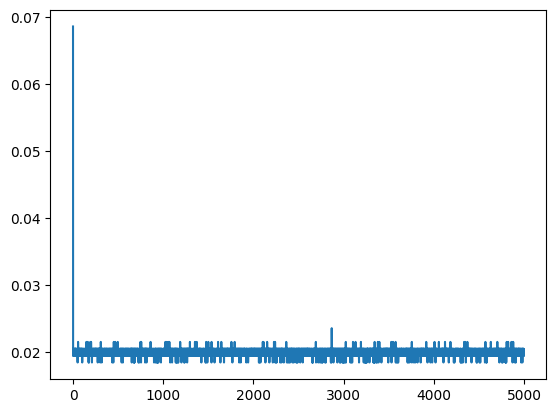

In [15]:
t = torch.rand((100,100), device="cuda")
times = running_times(lambda: t @ t @ t, 5000)
plt.plot(times)
fit_gaussian_mixture(times).rtimes_per_mean

In [16]:
from math import prod

In [17]:
prod(next(iter(fit_gaussian_mixture(times).rtimes_per_mean.items())))

98.15756442211568

In [18]:
t = torch.rand((100,100), device="cuda")
for _ in range(5):
    times = running_times(lambda: t @ t @ t, 5000, "ms")
    rtimes_per_mean = list(fit_gaussian_mixture(times).rtimes_per_mean.items())
    print(rtimes_per_mean)
    if len(rtimes_per_mean) == 1:
        continue
    print(prod(rtimes_per_mean[0]))
    sleep(2)

[(0.0197568249589498, 4980)]
[(0.022072479456241276, 127), (0.019822212928674966, 4853)]
2.803204890942642
[(0.02474057112779764, 668), (0.019765626863492064, 4312)]
16.526701513368824
[(0.024674235086523822, 670), (0.01975319769616736, 4310)]
16.53173750797096
[(0.02470739746977162, 584), (0.019767328198797743, 4396)]
14.429120122346626


In [19]:
t = torch.rand((1024,1024), device="cuda")
for _ in range(5):
    times = running_times(lambda: t @ t @ t, 1024, "ms")
    rtimes_per_mean = list(fit_gaussian_mixture(times).rtimes_per_mean.items())
    print(rtimes_per_mean)
    if len(rtimes_per_mean) == 1:
        continue
    print(prod(rtimes_per_mean[0]))
    sleep(2)

[(0.34133333659597803, 1), (0.31129598617553644, 667), (0.26701682806015015, 336)]
0.34133333659597803
[(0.34118911036303345, 213), (0.2665701157751337, 791)]
72.67328050732613
[(0.3396457960765142, 553), (0.2666373406836305, 451)]
187.82412523031235
[(0.3403667405492863, 547), (0.29900801181793146, 1), (0.2673717890130846, 456)]
186.1806070804596
[(0.34010370919503363, 332), (0.26667581121658995, 672)]
112.91443145275116


In [20]:
t = torch.rand((16,16), device="cuda")
for _ in range(5):
    times = running_times(lambda: t @ t @ t @ t @ t, 4096, "ms")
    rtimes_per_mean = list(fit_gaussian_mixture(times).rtimes_per_mean.items())
    print(rtimes_per_mean)
    if len(rtimes_per_mean) == 1:
        continue
    print(prod(rtimes_per_mean[0]))
    sleep(2)

[(0.029159134615933047, 997), (0.023315884465960546, 3079)]
29.07165721208525
[(0.029134469253040057, 852), (0.023331876933014632, 3224)]
24.82256780359013
[(0.02914931798530994, 758), (0.023378670361823364, 3318)]
22.095183032864934
[(0.029011187284145642, 647), (0.023401879812506167, 3429)]
18.77023817284223
[(0.029064707108097658, 1432), (0.023424943469700095, 2644)]
41.62066057879585


In [21]:
t = torch.rand((128,128), device="cuda")
for _ in range(5):
    times = running_times(lambda: t @ t @ t @ t @ t, 4096, "ms")
    rtimes_per_mean = list(fit_gaussian_mixture(times).rtimes_per_mean.items())
    print(rtimes_per_mean)
    if len(rtimes_per_mean) == 1:
        continue
    print(prod(rtimes_per_mean[0]))
    sleep(2)

[autoreload of conch.bench failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/trist/conch/conch/bench.py", line 321
    def auto_grid_search(fn, )
                              ^
SyntaxError: expected ':'
]


[(0.044961093480871545, 628), (0.0356139440702849, 3448)]
28.23556670598733
[(0.04498024269888983, 1202), (0.03567476186241226, 2874)]
54.06625172406558
[(0.04495584072903135, 777), (0.03560130551421463, 3299)]
34.930688246457365
[(0.044980917640608395, 1282), (0.03561973459752081, 2794)]
57.665536415259965
[(0.04495836838966661, 902), (0.03553834994147629, 3174)]
40.55244828747928


In [22]:
from functools import reduce
from operator import matmul

In [23]:
t = torch.empty((128,128), device="cuda")
for _ in range(5):
    times = running_times(lambda: reduce(matmul, (t for _ in range(3))), 4096, "ms")
    rtimes_per_mean = list(fit_gaussian_mixture(times).rtimes_per_mean.items())
    print(rtimes_per_mean)
    if len(rtimes_per_mean) == 1:
        continue
    print(prod(rtimes_per_mean[0]))
    sleep(2)

[(0.024628737864473477, 946), (0.019997514352682606, 3130)]
23.29878601979191
[(0.024658873781331275, 819), (0.019993172689666924, 3257)]
20.195617626910316
[(0.024631416180998907, 736), (0.01999321535906407, 3340)]
18.128722309215195
[(0.024629311236100526, 665), (0.01997415573470568, 3411)]
16.37849197200685
[(0.02467662953894649, 540), (0.02005654270743168, 3536)]
13.325379951031104


Most reliable warmup method:

```python
t = torch.empty((128, 128), device='cuda')
for _ in range(4096):
    t = t @ t @ t
```

In [24]:
t = torch.empty((128, 128), device='cuda')
for _ in range(4096):
    t = t @ t @ t
db()

[autoreload of conch.bench failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/trist/conch/conch/bench.py", line 321
    def auto_grid_search(fn, grid: MetaParamGrid)
                                                 ^
SyntaxError: expecte

3.654143810272217


### Warmup canary

The warmup function should ideally act as a warmup canary - to tell us if the GPU is warm. For this purpose, it should experience a big difference in performance when the GPU is warm vs cold.

[autoreload of conch.bench failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/trist/conch/conch/bench.py", line 324
    def results_to_df(results, top_n: int = 10):
    ^^^
IndentationError: expected an indented block after function defi

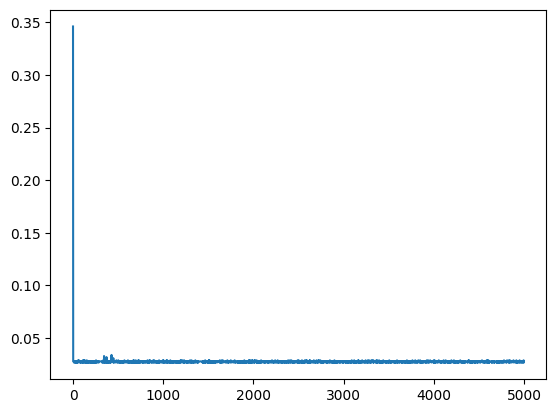

In [25]:
t = torch.rand((128,128), device="cuda")
times = running_times(lambda: t @ t @ t @ t, 5000)
plt.plot(times)

In [26]:
from conch.bench import ensure_warm_gpu, _GPU_WARMUP_RUNTIME

print(_GPU_WARMUP_RUNTIME)

None


[autoreload of conch.bench failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/trist/conch/conch/bench.py", line 326
    def results_to_df(results, top_n: int = 10):
    ^^^
IndentationError: expected an indented block after function defi

In [27]:
%%time

ensure_warm_gpu()
ensure_warm_gpu()
ensure_warm_gpu()
torch.cuda.synchronize()

CPU times: user 1.04 s, sys: 2.97 ms, total: 1.05 s
Wall time: 1.1 s


Check that although calling `ensure_warm_gpu` with a cold GPU is slow, subsequent calls while the GPU is warm are fast.

In [28]:
%time ensure_warm_gpu(); torch.cuda.synchronize()

%time [ensure_warm_gpu() for _ in range(100)];

CPU times: user 98.9 ms, sys: 79 µs, total: 99 ms
Wall time: 119 ms
CPU times: user 3.49 s, sys: 65.4 ms, total: 3.55 s
Wall time: 3.63 s


In [29]:
from conch.bench import auto_bench

In [30]:
krnl = lambda: attention(q2, k2, v2, 0.2)

In [31]:
do_bench(krnl)[0], do_bench(krnl)[0], do_bench(krnl)[0]

(3.6510720252990723, 3.6531200408935547, 3.6526079177856445)

In [32]:
auto_bench(krnl), auto_bench(krnl), auto_bench(krnl)

(3.752959966659546, 3.7442559003829956, 3.721216082572937)

In [33]:
%time [do_bench(krnl) for _ in range(16)];

%time [auto_bench(krnl) for _ in range(16)];

CPU times: user 1.89 s, sys: 508 ms, total: 2.39 s
Wall time: 2.47 s
CPU times: user 448 ms, sys: 82.6 ms, total: 530 ms
Wall time: 530 ms


In [34]:
from conch.bench import auto_grid_search

In [ ]:
auto_grid_search()